In [ ]:
!pip -q install tensorflow~=2.5.0 numpy~=1.19.5 matplotlib~=3.2.2 tensorflow_hub~=0.12.0 cartopy~=0.19.0

!pip install pyproj

!pip install boto3
!pip install botocore

     |████████████████████████████████| 460.3 MB 7.2 kB/s 
     |████████████████████████████████| 14.8 MB 45.4 MB/s 
     |████████████████████████████████| 12.1 MB 43.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 4.0 MB 53.1 MB/s 
     |████████████████████████████████| 1.2 MB 45.1 MB/s 
     |████████████████████████████████| 132 kB 55.7 MB/s 
     |████████████████████████████████| 462 kB 66.9 MB/s 
     |████████████████████████████████| 44 kB 2.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 

In [ ]:
# Workaround for cartopy crashes due to the shapely installed by default in
# google colab kernel (https://github.com/anitagraser/movingpandas/issues/81):
!pip uninstall -y shapely
!pip install shapely --no-binary shapely

Found existing installation: Shapely 1.8.1.post1
Uninstalling Shapely-1.8.1.post1:
  Successfully uninstalled Shapely-1.8.1.post1
     |████████████████████████████████| 198 kB 11.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shapely: filename=Shapely-1.8.1.post1-cp37-cp37m-linux_x86_64.whl size=665177 sha256=1a1dd724dda6a6881502c822eb5e8e5dc6fb66f55db78eb4bb09156843dc94ea
  Stored in directory: /root/.cache/pip/wheels/ea/8d/2f/ab748b8a432b3c6cd72e751b3bca17c5a9ed4538b1e78467e6
Successfully built shapely
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


## Imports:

In [ ]:
import datetime
import os
import cartopy

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import shapely.geometry as sgeom
import tensorflow as tf
import tensorflow_hub

from google.colab import auth

import matplotlib.colors as mcolors
from pyproj import Proj


/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## Dataset location

In [ ]:
# This Google Cloud Storage (GCS) bucket is free to access and contains an
# example subset of the full dataset (just the first shard of each
# split/variant):
EXAMPLE_DATASET_BUCKET_PATH = "gs://dm-nowcasting-example-data/datasets/nowcasting_open_source_osgb/nimrod_osgb_1000m_yearly_splits/radar/20200718"

# This bucket is requester-pays and will require authentication. It contains the
# full dataset. We recommend downloading a local copy first and updating
# ROOT_DATASET_DIR below to the local path. This should save on transfer costs
# and speed up training.
FULL_DATASET_BUCKET_PATH = "gs://dm-nowcasting/datasets/nowcasting_open_source_osgb/nimrod_osgb_1000m_yearly_splits/radar/20200718"

# Update this as required:
DATASET_ROOT_DIR = EXAMPLE_DATASET_BUCKET_PATH

Use this to authenticate as required for access to GCS buckets:

## Dataset reader code



In [ ]:
_FEATURES = {name: tf.io.FixedLenFeature([], dtype)
             for name, dtype in [
               ("radar", tf.string), ("sample_prob", tf.float32),
               ("osgb_extent_top", tf.int64), ("osgb_extent_left", tf.int64),
               ("osgb_extent_bottom", tf.int64), ("osgb_extent_right", tf.int64),
               ("end_time_timestamp", tf.int64),
             ]}

_SHAPE_BY_SPLIT_VARIANT = {
    ("train", "random_crops_256"): (24, 256, 256, 1),
    ("valid", "subsampled_tiles_256_20min_stride"): (24, 256, 256, 1),
    ("test", "full_frame_20min_stride"): (24, 1536, 1280, 1),
    ("test", "subsampled_overlapping_padded_tiles_512_20min_stride"): (24, 512, 512, 1),
}

_MM_PER_HOUR_INCREMENT = 1/32.
_MAX_MM_PER_HOUR = 128.
_INT16_MASK_VALUE = -1


def parse_and_preprocess_row(row, split, variant):
  result = tf.io.parse_example(row, _FEATURES)
  shape = _SHAPE_BY_SPLIT_VARIANT[(split, variant)]
  radar_bytes = result.pop("radar")
  radar_int16 = tf.reshape(tf.io.decode_raw(radar_bytes, tf.int16), shape)
  mask = tf.not_equal(radar_int16, _INT16_MASK_VALUE)
  radar = tf.cast(radar_int16, tf.float32) * _MM_PER_HOUR_INCREMENT
  radar = tf.clip_by_value(
      radar, _INT16_MASK_VALUE * _MM_PER_HOUR_INCREMENT, _MAX_MM_PER_HOUR)
  result["radar_frames"] = radar
  result["radar_mask"] = mask
  return result


def reader(split="train", variant="random_crops_256", shuffle_files=False):
  """Reader for open-source nowcasting datasets.
  
  Args:
    split: Which yearly split of the dataset to use:
      "train": Data from 2016 - 2018, excluding the first day of each month.
      "valid": Data from 2016 - 2018, only the first day of the month.
      "test": Data from 2019.
    variant: Which variant to use. The available variants depend on the split:
      "random_crops_256": Available for the training split. 24x256x256 pixel
        crops, sampled with a bias towards crops containing rainfall. Crops at
        all spatial and temporal offsets were able to be sampled, some crops may
        overlap.
      "subsampled_tiles_256_20min_stride": Available for the validation set.
        Non-spatially-overlapping 24x256x256 pixel crops, subsampled from a
        regular spatial grid with stride 256x256 pixels, and a temporal stride
        of 20mins (4 timesteps at 5 minute resolution). Sampling favours crops
        containing rainfall.
      "subsampled_overlapping_padded_tiles_512_20min_stride": Available for the
        test set. Overlapping 24x512x512 pixel crops, subsampled from a
        regular spatial grid with stride 64x64 pixels, and a temporal stride
        of 20mins (4 timesteps at 5 minute resolution). Subsampling favours
        crops containing rainfall.
        These crops include extra spatial context for a fairer evaluation of
        the PySTEPS baseline, which benefits from this extra context. Our other
        models only use the central 256x256 pixels of these crops.
      "full_frame_20min_stride": Available for the test set. Includes full
        frames at 24x1536x1280 pixels, every 20 minutes with no additional
        subsampling.
    shuffle_files: Whether to shuffle the shard files of the dataset
      non-deterministically before interleaving them. Recommended for the
      training set to improve mixing and read performance (since
      non-deterministic parallel interleave is then enabled).

  Returns:
    A tf.data.Dataset whose rows are dicts with the following keys:

    "radar_frames": Shape TxHxWx1, float32. Radar-based estimates of
      ground-level precipitation, in units of mm/hr. Pixels which are masked
      will take on a value of -1/32 and should be excluded from use as
      evaluation targets. The coordinate reference system used is OSGB36, with
      a spatial resolution of 1000 OSGB36 coordinate units (approximately equal
      to 1km). The temporal resolution is 5 minutes.
    "radar_mask": Shape TxHxWx1, bool. A binary mask which is False
      for pixels that are unobserved / unable to be inferred from radar
      measurements (e.g. due to being too far from a radar site). This mask
      is usually static over time, but occasionally a whole radar site will
      drop in or out resulting in large changes to the mask, and more localised
      changes can happen too. 
    "sample_prob": Scalar float. The probability with which the row was
      sampled from the overall pool available for sampling, as described above
      under 'variants'. We use importance weights proportional to 1/sample_prob
      when computing metrics on the validation and test set, to reduce bias due
      to the subsampling.
    "end_time_timestamp": Scalar int64. A timestamp for the final frame in
      the example, in seconds since the UNIX epoch (1970-01-01 00:00:00 UTC).
    "osgb_extent_left", "osgb_extent_right", "osgb_extent_top",
    "osgb_extent_bottom":
      Scalar int64s. Spatial extent for the crop in the OSGB36 coordinate
      reference system.
  """
  shards_glob = os.path.join(DATASET_ROOT_DIR, split, variant, "*.tfrecord.gz")
  shard_paths = tf.io.gfile.glob(shards_glob)
  shards_dataset = tf.data.Dataset.from_tensor_slices(shard_paths)
  if shuffle_files:
    shards_dataset = shards_dataset.shuffle(buffer_size=len(shard_paths))
  return (
      shards_dataset
      .interleave(lambda x: tf.data.TFRecordDataset(x, compression_type="GZIP"),
                  num_parallel_calls=tf.data.AUTOTUNE,
                  deterministic=not shuffle_files)
      .map(lambda row: parse_and_preprocess_row(row, split, variant),
           num_parallel_calls=tf.data.AUTOTUNE)
      # Do your own subsequent repeat, shuffle, batch, prefetch etc as required.
  )

def rescale_linear(array, new_min, new_max):
    """Rescale an arrary linearly."""
    minimum, maximum = np.min(array), np.max(array)
    m = (new_max - new_min) / (maximum - minimum)
    b = new_min - m * minimum
    return m * array + b

def mrms_parse(element):
    print('parsing')
    
    '''
     "radar": bytes_feature(serialize_array(example)), # tf.string
        "sample_prob": float_feature(1.),  # tf.float32
        "central_latitude":int64_feature(int(90.0)),
        "central_longitude":int64_feature(int(metadata.straight_vertical_longitude_from_pole)),
        "true_scale_latitude":int64_feature(int(metadata.standard_parallel)),
        "earth_radius":int64_feature(int(metadata.earth_radius))
    '''
    features = {
      'central_longitude': tf.io.FixedLenFeature([], tf.int64), 
      'central_latitude':tf.io.FixedLenFeature([], tf.int64),
      'radar' : tf.io.FixedLenFeature([], tf.string),
      'true_scale_latitude':tf.io.FixedLenFeature([], tf.int64),
      'earth_radius':tf.io.FixedLenFeature([], tf.int64),
      'x':tf.io.FixedLenFeature([], tf.string),
      'y':tf.io.FixedLenFeature([], tf.string),
        
    }
    
    
    result = tf.io.parse_single_example(element, features) 
    radar_bytes = result['radar']#result.pop("radar")
    shape = (881, 1121)

    radar_float32 = tf.reshape(tf.io.parse_tensor(radar_bytes, tf.float32), shape)
    print('radar_float32')
    print(radar_float32)
    #mask = tf.not_equal(radar_float32, _INT16_MASK_VALUE)

    mask = tf.not_equal(radar_float32, _INT16_MASK_VALUE)

    #radar_float32 = radar_float32 * _MM_PER_HOUR_INCREMENT
    radar = tf.clip_by_value(
      radar_float32, _INT16_MASK_VALUE * _MM_PER_HOUR_INCREMENT, _MAX_MM_PER_HOUR) 
    #radar =  rescale_linear(radar_float32.numpy(),0,15)
    '''
    #get our 'feature'-- our image -- and reshape it appropriately
    feature = tf.io.parse_tensor(radar, out_type=tf.int16)
    feature = tf.reshape(feature, shape=[256,256,1])
    return (feature, label)
    '''
    #result["radar_frames"] = radar_float32
    # #result["radar_mask"] = mask
    result['x'] = tf.io.parse_tensor(result['x'], tf.float64) 
    result['y'] = tf.io.parse_tensor(result['y'], tf.float64)

    result['x'] = tf.cast(result['x'], tf.float32) 
    result['y'] = tf.cast(result['y'], tf.float32)


    radar= tf.cast(radar, tf.float32)

    print(result)
    
    return {'radar_frames':radar,
            "radar_mask":mask,
            'central_longitude':result['central_longitude'],
            'central_latitude':result['central_latitude'],
            'true_scale_latitude':result['true_scale_latitude'],
            "x":result["x"],
            "y":result["y"],
            'earth_radius': result['earth_radius']}

def parsegrib(element):
    print('parsing')
    features = {
      'latmin': tf.io.FixedLenFeature([], tf.int64), 
      'latmax':tf.io.FixedLenFeature([], tf.int64),
      'radar' : tf.io.FixedLenFeature([], tf.string),
      'latitude' : tf.io.FixedLenFeature([], tf.string),
      'longitude' : tf.io.FixedLenFeature([], tf.string),
        
      'lonmin':tf.io.FixedLenFeature([], tf.int64),
      'lonmax':tf.io.FixedLenFeature([], tf.int64),
      'end_time_timestamp':tf.io.FixedLenFeature([], tf.int64)  
        
    }
    
    
    result = tf.io.parse_single_example(element, features) 
    radar_bytes = result['radar']#result.pop("radar")
    shape = (3500, 7000)

    radar_float32 = tf.reshape(tf.io.parse_tensor(radar_bytes, tf.float32), shape)
    print('radar bytes')
    print(radar_bytes)
    result['latitude'] = tf.io.parse_tensor(result['latitude'], tf.float64) 
    result['longitude'] = tf.io.parse_tensor(result['longitude'], tf.float64)

    result['latitude'] = tf.cast(result['latitude'], tf.float32) 
    result['longitude'] = tf.cast(result['longitude'], tf.float32)


    mask = tf.not_equal(radar_float32, _INT16_MASK_VALUE)

    #radar = radar_float64 * _MM_PER_HOUR_INCREMENT
    radar = tf.clip_by_value(
      radar_float32, _INT16_MASK_VALUE * _MM_PER_HOUR_INCREMENT, _MAX_MM_PER_HOUR)
    
    
    '''
    #get our 'feature'-- our image -- and reshape it appropriately
    feature = tf.io.parse_tensor(radar, out_type=tf.int16)
    feature = tf.reshape(feature, shape=[256,256,1])
    return (feature, label)
    '''
    #result["radar_frames"] = radar_float64
    #result["radar_mask"] = mask
    #result['x'] = tf.io.parse_tensor(result['x'], tf.float64) 
    #result['y'] = tf.io.parse_tensor(result['y'], tf.float64)
    #print(result)
    
    return {'radar_frames':radar,
            "radar_mask":mask,
            'latmin':result['latmin'],
            'latmax':result['latmax'],
            'lonmin':result['lonmin'], 
            'lonmax': result['lonmax'],
            'longitude':result['longitude'],
            'latitude':result['latitude'],
            'end_time_timestamp':result['end_time_timestamp']}

def get_dataset_mrms(filename):
  #create the dataset
  #dataset = tf.data.TFRecordDataset(filename)

  #pass every single feature through our mapping function
  #dataset = dataset.map(
  #    parse_tfr_element
  #)
    dataset = tf.data.TFRecordDataset(filename, compression_type="GZIP") 
   
    print(dataset)
    '''
    for raw_record in dataset.take(1):
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        print(example)
    '''
    dataset = dataset.map(mrms_parse)
  
    return dataset

def get_dataset_grib(filename):
  #create the dataset
  #dataset = tf.data.TFRecordDataset(filename)

  #pass every single feature through our mapping function
  #dataset = dataset.map(
  #    parse_tfr_element
  #)
    dataset = tf.data.TFRecordDataset(filename, compression_type="GZIP") 
   
    print(dataset) 
    dataset = dataset.map(parsegrib)

    return dataset

def graphMrms(row):
    globe = cartopy.crs.Globe(semimajor_axis=row['earth_radius'].numpy()) 
    proj = cartopy.crs.Stereographic(central_latitude=row['central_latitude'].numpy(), 
                        central_longitude= row['central_longitude'].numpy() ,
                        true_scale_latitude=row['true_scale_latitude'].numpy(), 
                        globe=globe)
 
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1, projection=proj)

    # draw coastlines, state and country boundaries, edge of map.
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS)
    ax.add_feature(cartopy.feature.STATES)

    # draw filled contours.
    clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
             50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750]
    # In future MetPy
    # norm, cmap = ctables.registry.get_with_boundaries('precipitation', clevs)
    cmap_data = [(1.0, 1.0, 1.0),
                 (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
                 (0.0, 1.0, 1.0),
                 (0.0, 0.8784313797950745, 0.501960813999176),
                 (0.0, 0.7529411911964417, 0.0),
                 (0.501960813999176, 0.8784313797950745, 0.0),
                 (1.0, 1.0, 0.0),
                 (1.0, 0.6274510025978088, 0.0),
                 (1.0, 0.0, 0.0),
                 (1.0, 0.125490203499794, 0.501960813999176),
                 (0.9411764740943909, 0.250980406999588, 1.0),
                 (0.501960813999176, 0.125490203499794, 1.0),
                 (0.250980406999588, 0.250980406999588, 1.0),
                 (0.125490203499794, 0.125490203499794, 0.501960813999176),
                 (0.125490203499794, 0.125490203499794, 0.125490203499794),
                 (0.501960813999176, 0.501960813999176, 0.501960813999176),
                 (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
                 (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
                 (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
                 (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
                 (0.4000000059604645, 0.20000000298023224, 0.0)]
    cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
    norm = mcolors.BoundaryNorm(clevs, cmap.N)

    data = row['radar_frames']#[500:950, 800:1100] 
    x = row['x']#nc.variables['x'][:]
    y = row['y']#nc.variables['y'][:]
    x = np.array(x)
    y = np.array(y)
    cs = ax.contourf(x, y, data, clevs, cmap='jet',vmin= 0,vmax = 15)#cmap=cmap, norm=norm)
    cs = ax.imshow(data, extent=[x.min(), x.max(), y.min(), y.max()], cmap='jet', vmin=0, vmax=15, origin='upper', interpolation='none', transform=proj)
    # add colorbar.
    cbar = plt.colorbar(cs, orientation='horizontal')
    cbar.set_label("millimeter")

    
    # cropp data 
    
    #ax.set_title(prcpvar.long_name + ' for period ending ' + nc.creation_time)
    plt.show()

def graphGribOG(row,map_extent = [-106.0, -78.05576, 30.0, 47.603355]):
    globe = cartopy.crs.Globe(semimajor_axis=6371200.0) 
    proj = cartopy.crs.Stereographic(central_latitude=90, 
                    central_longitude= -105,
                    true_scale_latitude=60, 
                    globe=globe)
 
    fig = plt.figure(figsize=(10, 10))
    crs = cartopy.crs.PlateCarree()
    ax = plt.axes(projection=crs)
    
    ax.set_extent(map_extent, crs=crs)
    
    # draw coastlines, state and country boundaries, edge of map.
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS)
    lakes = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '10m')
    ax.add_feature(lakes, edgecolor='gold', linewidth=0.25)

    data = row['radar_frames']#[500:950, 800:1100] 
    lons = np.array(row['longitude'])
    lats = np.array(row['latitude'])
    
    convert = Proj(proj.proj4_init)
    X, Y = np.meshgrid(lons, lats)
    X, Y = convert(X, Y)
    print(X.shape, Y.shape)
    print(X.min(), X.max(), Y.min(), Y.max())

    cs = ax.imshow(data, extent=[X.min(), X.max(), Y.min(), Y.max()], cmap='jet', vmin=0, vmax=15, origin='upper', interpolation='none', transform=proj)
    # add colorbar.
    cbar = plt.colorbar(cs, orientation='horizontal')
    cbar.set_label("millimeter")

    plt.show()

def graphGrib(row,map_extent = [-106.0, -78.05576, 30.0, 47.603355]):
    globe = cartopy.crs.Globe(semimajor_axis=6371200.0) 
    proj = cartopy.crs.Stereographic(central_latitude=90, 
                    central_longitude= -105,
                    true_scale_latitude=60, 
                    globe=globe)
 
    fig = plt.figure(figsize=(10, 10))
    crs = cartopy.crs.PlateCarree()
    ax = plt.axes(projection=crs)
    
    ax.set_extent(map_extent, crs=crs)
    
    # draw coastlines, state and country boundaries, edge of map.
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS)
    lakes = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '10m')
    ax.add_feature(lakes, edgecolor='gold', linewidth=0.25)

    waterloo = mpatches.Circle((-80.516670, 43.466667), 0.085, linestyle='solid', edgecolor='black', facecolor='gold')
    ax.add_patch(waterloo)
    big_loo = mpatches.Circle((-80.516670, 43.466667), 0.14, linestyle='solid', edgecolor='gold', facecolor='none')
    ax.add_patch(big_loo)

    data = row['radar_frames']#[500:950, 800:1100] 
    lons = np.array(row['longitude'])
    lats = np.array(row['latitude'])
    
    convert = Proj(proj.proj4_init)
    X, Y = np.meshgrid(lons, lats)
    X, Y = convert(X, Y)
    print(X.shape, Y.shape)
    print(X.min(), X.max(), Y.min(), Y.max())

    cs = ax.imshow(data, extent=[X.min(), X.max(), Y.min(), Y.max()], cmap='jet', vmin=0, vmax=15, origin='upper', interpolation='none', transform=proj)
    # add colorbar.
    cbar = plt.colorbar(cs, orientation='horizontal')
    cbar.set_label("millimeter")

    plt.show()

## boto3 : pull and upload

In [ ]:
import boto3 
from botocore import UNSIGNED
from botocore.config import Config
import matplotlib.patches as mpatches
import io
import os

waterloo_specBounds = [-82.2, -79.35576, 42.7, 44.603355]
map_extent_crop = [-86.0, -78.05576, 39.0, 47.603355]
gribGroundTruthsPath = "examples/predictions/mrms_24hr/"
TFRecordPath = "test-predictions/mrms_24hr/"

In [ ]:
#pull tf records in
def getS3FileNames(TFRecordPath):
  s3_client = boto3.client( 's3',
        aws_access_key_id="",
        aws_secret_access_key="",
        region_name="us-east-1"
    )
      
  response = s3_client.list_objects_v2(Bucket="lumo-app", Prefix=TFRecordPath)#Prefix="test-predictions/grib_24hr/")

  #result = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)
  filenames = []
  if 'Contents' not in response:
    print('no data')
    return []
  for item in response['Contents']:
    files = item['Key']
    if( ".gz" in files):
      #print(files)
      filenames.append("s3://lumo-app/"+files) 

  return filenames

def get_dataset(filenames):
    #optional if you have more filefolders to got through.
    #return filenames
    print(filenames)
    #print(len(filenames))
    autotune = tf.data.experimental.AUTOTUNE
     
    options = tf.data.Options()
    options.experimental_deterministic = False
    #records = tf.data.Dataset.list_files(folder_path + '/*',shuffle=True).with_options(options)

    ds = tf.data.TFRecordDataset(filenames, compression_type="GZIP",
                           num_parallel_reads=autotune).repeat()
    ds = ds.map(parsegrib, num_parallel_calls=autotune)
    ds = ds.batch(len(filenames))
    ds = ds.prefetch(autotune)
    return ds
# get converted 

filenames = getS3FileNames(TFRecordPath)
print(filenames)
print(len(filenames))
if( len(filenames) < 4):
  print('not enough files')
  #break
filenames =  filenames[0:4]
#print(first_four)

# add first 4 as png w 00 index 

data = get_dataset(filenames)
print(data)
#print(len(list(data)))
#for x in data:
  #print(x)

gribdata = next(iter( data )) 
print() 

['s3://lumo-app/test-predictions/mrms_24hr/MRMS_RadarOnly_QPE_24H_00.00_20220308-200000.tfrecord.gz', 's3://lumo-app/test-predictions/mrms_24hr/MRMS_RadarOnly_QPE_24H_00.00_20220308-210000.tfrecord.gz', 's3://lumo-app/test-predictions/mrms_24hr/MRMS_RadarOnly_QPE_24H_00.00_20220308-220000.tfrecord.gz', 's3://lumo-app/test-predictions/mrms_24hr/MRMS_RadarOnly_QPE_24H_00.00_20220308-230000.tfrecord.gz', 's3://lumo-app/test-predictions/mrms_24hr/MRMS_RadarOnly_QPE_24H_00.00_20220309-000000.tfrecord.gz', 's3://lumo-app/test-predictions/mrms_24hr/MRMS_RadarOnly_QPE_24H_00.00_20220309-010000.tfrecord.gz', 's3://lumo-app/test-predictions/mrms_24hr/MRMS_RadarOnly_QPE_24H_00.00_20220309-020000.tfrecord.gz', 's3://lumo-app/test-predictions/mrms_24hr/MRMS_RadarOnly_QPE_24H_00.00_20220309-030000.tfrecord.gz', 's3://lumo-app/test-predictions/mrms_24hr/MRMS_RadarOnly_QPE_24H_00.00_20220309-040000.tfrecord.gz', 's3://lumo-app/test-predictions/mrms_24hr/MRMS_RadarOnly_QPE_24H_00.00_20220309-050000.tfr

In [ ]:
 
def save_animation(field, latlong_bbox, xy_bbox, cmap, end_timestamp):
  s3_client = boto3.client( 's3',
          aws_access_key_id="",
          aws_secret_access_key="",
          region_name="us-east-1"
      )
      
  response = s3_client.list_objects_v2(Bucket="lumo-app", Prefix="test-predictions/mrms_grib/")
  if 'Contents' in response:
      for object in response['Contents']:
          print('Deleting', object['Key'])
          s3_client.delete_object(Bucket="lumo-app", Key=object['Key'])
              
  for i in range(field.shape[0]):
      fig = plt.figure(figsize=(10, 10))

      transform = cartopy.crs.Geostationary(central_longitude=-75.0, satellite_height=35786023.0, sweep_axis='x')
      map_extent = latlong_bbox
      img_extent = xy_bbox
      crs = cartopy.crs.PlateCarree()
      ax = plt.axes(projection=crs)
      ax.set_extent(map_extent, crs=crs)

      # add the geographic boundaries
      countries = cartopy.feature.NaturalEarthFeature(category='cultural', name='admin_0_countries', scale='50m', facecolor='none')
      lakes = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '10m')
      ax.add_feature(countries, edgecolor='gold', linewidth=0.25)
      ax.add_feature(lakes, edgecolor='gold', linewidth=0.25)

      waterloo = mpatches.Circle((-80.516670, 43.466667), 0.085, linestyle='solid', edgecolor='black', facecolor='gold')
      ax.add_patch(waterloo)
      big_loo = mpatches.Circle((-80.516670, 43.466667), 0.14, linestyle='solid', edgecolor='gold', facecolor='none')
      ax.add_patch(big_loo)


      ax.imshow(field[i, ..., 0], origin='upper',
                  extent=img_extent,
                  transform=transform,
                  interpolation='none', cmap=cmap, vmin=170, vmax=378)
      
      img_data = io.BytesIO()
      fig.savefig(img_data, format='png', bbox_inches='tight')
      img_data.seek(0)
          
      session = boto3.Session(
          aws_access_key_id="",
          aws_secret_access_key="",
      )
      s3 = session.resource('s3')
      bucket = s3.Bucket("lumo-app")
      
      datetime_str = datetime.datetime.utcfromtimestamp(end_timestamp).strftime("%Y-%m-%d-%H%M")
      index_str = f'0{str(i)}' if i < 10 else str(i)
      #bucket.put_object(Body=img_data, ContentType='image/png', Key="test-predictions/mrms_grib/" + datetime_str)

      
      plt.close()

def plotBounds(lons,lats):
  globe = cartopy.crs.Globe(semimajor_axis=6371200.0) 
  proj = cartopy.crs.Stereographic(central_latitude=90, 
                      central_longitude= -105,
                      true_scale_latitude=60, 
                      globe=globe)
  
  lons = np.array(lons)#row['longitude'])
  lats = np.array(lats)#row['latitude'])
  
  convert = Proj(proj.proj4_init)
  X, Y = np.meshgrid(lons, lats)
  X, Y = convert(X, Y)
  #print(X.shape, Y.shape)
  print(X.min(), X.max(), Y.min(), Y.max())
  return [X.min(), X.max(), Y.min(), Y.max()]

def plot_animation_grib(field,gribGroundTruthsPath,FrameData,map_extent = [-106.0, -78.05576, 30.0, 47.603355],figsize=None,
                   vmin=0, vmax=10, cmap="jet", **imshow_args):
  

    s3_client = boto3.client( 's3',
          aws_access_key_id="",
          aws_secret_access_key="",
          region_name="us-east-1"
    )
    #s3://lumo-app/examples/predictions/mrms_24hr/  
    response = s3_client.list_objects_v2(Bucket="lumo-app", Prefix="test-predictions/mrms_24hr/") #Prefix="test-predictions/mrms_grib/")
    #if 'Contents' in response:
    #    for object in response['Contents']:
    #        print('Deleting', object['Key'])
    #        s3_client.delete_object(Bucket="lumo-app", Key=object['Key'])
  
    for i in range(field.shape[0]):
      print(f'img : {i}')
      globe = cartopy.crs.Globe(semimajor_axis=6371200.0) 
      proj = cartopy.crs.Stereographic(central_latitude=90, 
                      central_longitude= -105,
                      true_scale_latitude=60, 
                      globe=globe)
  
      fig = plt.figure(figsize=(10, 10))
      crs = cartopy.crs.PlateCarree()
      ax = plt.axes(projection=crs)
      
      ax.set_extent(map_extent, crs=crs)
      
      # draw coastlines, state and country boundaries, edge of map.
      ax.coastlines()
      ax.add_feature(cartopy.feature.BORDERS)
      lakes = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '10m')
      ax.add_feature(lakes, edgecolor='gold', linewidth=0.25)

      waterloo = mpatches.Circle((-80.516670, 43.466667), 0.065, linestyle='solid', edgecolor='black', facecolor='gold')
      ax.add_patch(waterloo)
      big_loo = mpatches.Circle((-80.516670, 43.466667), 0.094, linestyle='solid', edgecolor='gold', facecolor='none')
      ax.add_patch(big_loo)

      #data = row['radar_frames']#[500:950, 800:1100] 
      #lons = np.array(row['longitude'])
      #lats = np.array(row['latitude'])
      
      #convert = Proj(proj.proj4_init)
      #X, Y = np.meshgrid(lons, lats)
      #X, Y = convert(X, Y)
      #print(X.shape, Y.shape)
      #print(X.min(), X.max(), Y.min(), Y.max())
      currentlat_lon =  FrameData[1] #img_lat_lon
      bg_frame = np.zeros((3500, 7000))
      print('f')
      print(field[i, ..., 0].shape)
      cs = ax.imshow(field[i, ..., 0], extent=[currentlat_lon[0], currentlat_lon[1], currentlat_lon[2], currentlat_lon[3]], cmap='jet', vmin=vmin, vmax=vmax, origin='upper', interpolation='none', transform=proj)
      # add colorbar.
      cbar = plt.colorbar(cs, orientation='horizontal')
      cbar.set_label("millimeter")

      plt.show()

      img_data = io.BytesIO()
      fig.savefig(img_data, format='png', bbox_inches='tight')
      img_data.seek(0)

      session = boto3.Session(
          aws_access_key_id="",
          aws_secret_access_key="",
      )
      s3 = session.resource('s3')
      bucket = s3.Bucket("lumo-app")

      datetime_str = datetime.datetime.utcfromtimestamp(FrameData[0][3]).strftime("%Y-%m-%d-%H%M")
      print(datetime_str)
      index_str = f'0{str(i)}' if i < 10 else str(i)
      
      index = "{:02d}".format(i)
      bucket.put_object(Body=img_data, ContentType='image/png', Key= gribGroundTruthsPath+index+"_"+datetime_str) #Key="test-predictions/mrms_grib/" +  "_"+index_str)


MRMS Stuff
 

Grib Data

In [ ]:
#w_specBounds = [-82.2, -79.35576, 42.5, 44.603355]
w_specBounds = [-82.2, -79.35576, 42.7, 44.603355]
w_specextent = [-83.2, -78.35576, 41.5, 45.603355]
#graphGrib(grib_file_row,[-82.2, -79.35576, 42.5, 44.603355])
gribdata['radar_frames'][0]
print(filenames)

['s3://lumo-app/test-predictions/mrms_24hr/MRMS_RadarOnly_QPE_24H_00.00_20220308-200000.tfrecord.gz', 's3://lumo-app/test-predictions/mrms_24hr/MRMS_RadarOnly_QPE_24H_00.00_20220308-210000.tfrecord.gz', 's3://lumo-app/test-predictions/mrms_24hr/MRMS_RadarOnly_QPE_24H_00.00_20220308-220000.tfrecord.gz', 's3://lumo-app/test-predictions/mrms_24hr/MRMS_RadarOnly_QPE_24H_00.00_20220308-230000.tfrecord.gz']


test
(4, 3500, 7000, 1)
s3://lumo-app/test-predictions/mrms_24hr/MRMS_RadarOnly_QPE_24H_00.00_20220308-200000.tfrecord.gz
radar check
0
tf.Tensor(
[[-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 ...
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]], shape=(3500, 7000), dtype=float32)
[[-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 ...
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]]
(256, 256) (256, 256)
1962390.044472766 2298615.2656209804 -4811504.64234

/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


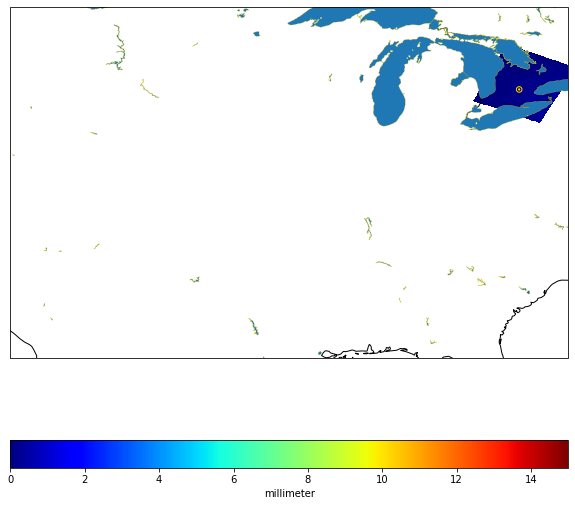

1962390.044472763 2298615.265620978 -4811504.642345356 -4433270.772618138
s3://lumo-app/test-predictions/mrms_24hr/MRMS_RadarOnly_QPE_24H_00.00_20220308-210000.tfrecord.gz
radar check
1
tf.Tensor(
[[-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 ...
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]], shape=(3500, 7000), dtype=float32)
[[-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 ...
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]]
(256, 256) (256, 256)
1

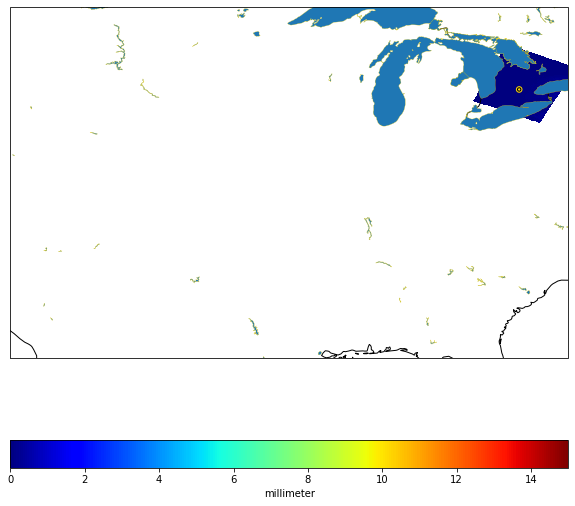

1962390.044472763 2298615.265620978 -4811504.642345356 -4433270.772618138
s3://lumo-app/test-predictions/mrms_24hr/MRMS_RadarOnly_QPE_24H_00.00_20220308-220000.tfrecord.gz
radar check
2
tf.Tensor(
[[-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 ...
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]], shape=(3500, 7000), dtype=float32)
[[-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 ...
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]]
(256, 256) (256, 256)
1

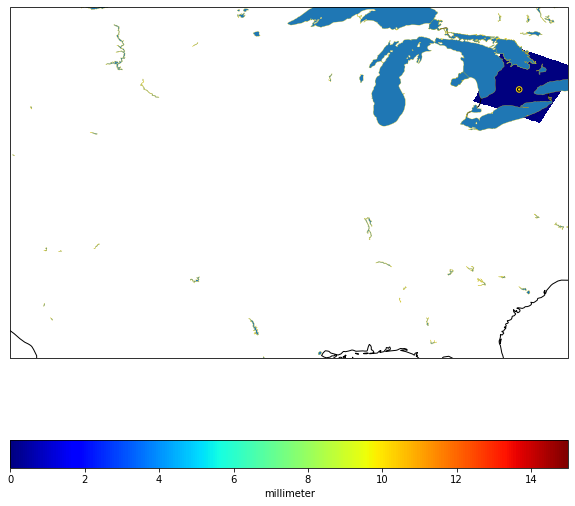

1962390.044472763 2298615.265620978 -4811504.642345356 -4433270.772618138
s3://lumo-app/test-predictions/mrms_24hr/MRMS_RadarOnly_QPE_24H_00.00_20220308-230000.tfrecord.gz
radar check
3
tf.Tensor(
[[-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 ...
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]], shape=(3500, 7000), dtype=float32)
[[-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 ...
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125 -0.03125]]
(256, 256) (256, 256)
1

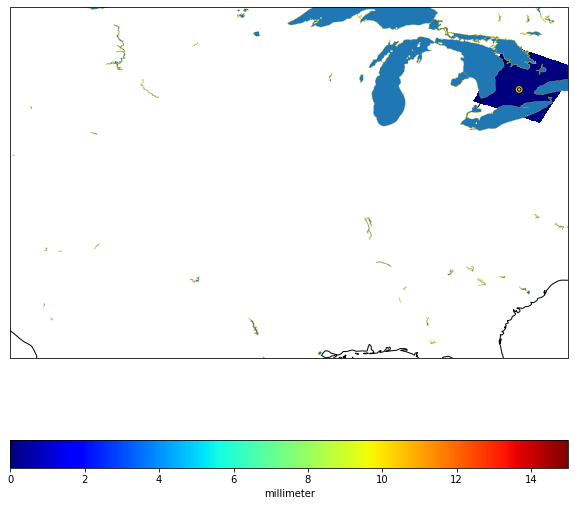

1962390.044472763 2298615.265620978 -4811504.642345356 -4433270.772618138


In [ ]:
#concat 4
radar_frames = np.empty((0,256,256,1))
big_radar_frames = np.empty((0,3500, 7000,1))
FrameRelatedData = []
grib_data = next(iter( data )) #gribdata.copy() #next(iter(  ))

print('test')
big_radar_frames = np.expand_dims(grib_data['radar_frames'], axis=3)
print(big_radar_frames.shape)
for i,fileName in enumerate(filenames):
  print(fileName)

  #grib_data['radar_frames'] = np.expand_dims(grib_data['radar_frames'],3)

  tmp =  grib_data.copy()
  #print(grib_data['radar_frames'].shape)
  #print(grib_data['radar_frames'][i].shape)

  #big_radar_frames = np.append(radar_frames, , axis=0)
  #grib_data['radar_frames']#.append(tmp['radar_frames'][i])
  

  #tmp['latitude']  = tmp['latitude'][i][1000:1256] 
  #tmp['longitude'] = tmp['longitude'][i][4844:5100] - 360 
  #tmp['radar_frames'] = tmp['radar_frames'][i][1000:1256, 4844:5100]

  print('radar check')
  print(i)
  print(tmp['radar_frames'][i])
  print(tmp['radar_frames'][i].numpy())
  test =  {}#grib_data.copy()
  #test['radar_frames'] =   rescale_linear(tmp['radar_frames'][i].numpy(), 0, 20) #tmp['radar_frames'][i][1000:1256, 4844:5100]
  #test['longitude'] = tmp['longitude'][i]
  #test['latitude'] = tmp['latitude'][i]
  #graphGrib(test)#map_extent_crop)
  tmp['radar_frames'] = rescale_linear(tmp['radar_frames'].numpy(), 0, 20)

  test['radar_frames'] =   tmp['radar_frames'][i][1000:1256, 4844:5100] #rescale_linear(tmp['radar_frames'][i][1000:1256, 4844:5100].numpy(), 0, 20) #tmp['radar_frames'][i][1000:1256, 4844:5100]
  test['longitude'] = tmp['longitude'][i][4844:5100]
  test['latitude'] = tmp['latitude'][i][1000:1256]
  #graphGrib(test,w_specBounds)#map_extent_crop)
  graphGrib(test)#map_extent_crop)

  #radar_frames.append(tmp['radar_frames'][i])
  radar_frames = np.append(radar_frames, np.expand_dims(np.expand_dims(tmp['radar_frames'][i][1000:1256, 4844:5100], axis=2), axis=0) , axis=0)
  #radar_frames = np.append(radar_frames, np.expand_dims(np.expand_dims(rescale_linear(tmp['radar_frames'][i][1000:1256, 4844:5100].numpy(), 0, 20), axis=2), axis=0) , axis=0)

  
  #latNdLongBounds.append(plotBounds(tmp['longitude'][i][4844:5100] - 360 , tmp['latitude'][i][1000:1256]) )
  FrameRelatedData.append( (grib_data['end_time_timestamp'],plotBounds(tmp['longitude'][i][4844:5100] - 360 , tmp['latitude'][i][1000:1256]))  )

  #print(tmp['longitude'])
  #print(tmp['longitude'][4844:5100])
  #print('grib og')
  #graphGrib(tmp,map_extent_crop)
   

#latNdLongBounds

In [ ]:
radar_frames.shape  

(4, 256, 256, 1)

## Reading a row from the training set and inspecting types/shapes/values

In [ ]:
#row = next(iter(reader(split="train", variant="random_crops_256")))
#{k: v.numpy() for k, v in row.items() if v.shape.ndims == 0}

Decoding the end_time_timestamp:

In [ ]:
#datetime.datetime.utcfromtimestamp(row["end_time_timestamp"]).isoformat()

## Visualization helpers

In [ ]:
matplotlib.rc('animation', html='jshtml')

def plot_animation(field, figsize=None,
                   vmin=0, vmax=10, cmap="jet", **imshow_args):
  
  print('plot animation: vmin:',vmin, " vmax: ",vmax)

  fig = plt.figure(figsize=figsize)
  ax = plt.axes()
  ax.set_axis_off()
  plt.close() # Prevents extra axes being plotted below animation
  img = ax.imshow(field[0, ..., 0], vmin=vmin, vmax=vmax, cmap=cmap, **imshow_args)

  def animate(i):
    img.set_data(field[i, ..., 0])
    return (img,)

  return animation.FuncAnimation(
      fig, animate, frames=field.shape[0], interval=24, blit=False)


class ExtendedOSGB(cartopy.crs.OSGB):
  """MET office radar data uses OSGB36 with an extended bounding box."""

  def __init__(self):
    super().__init__(approx=False)

  @property
  def x_limits(self):
    return (-405000, 1320000)

  @property
  def y_limits(self):
    return (-625000, 1550000)

  @property
  def boundary(self):
    x0, x1 = self.x_limits
    y0, y1 = self.y_limits
    return sgeom.LinearRing([(x0, y0), (x0, y1), (x1, y1), (x1, y0), (x0, y0)])


def plot_rows_on_map(rows, field_name="radar_frames", timestep=0, num_rows=None,
                     cbar_label=None, **imshow_kwargs):
  fig = plt.figure(figsize=(10, 10))
  axes = fig.add_subplot(1, 1, 1, projection=ExtendedOSGB())
  if num_rows is None:
    num_rows = next(iter(rows.values())).shape[0]
  for b in range(num_rows):
    extent = (rows["osgb_extent_left"][b].numpy(),
              rows["osgb_extent_right"][b].numpy(),
              rows["osgb_extent_bottom"][b].numpy(),
              rows["osgb_extent_top"][b].numpy())
    im = axes.imshow(rows[field_name][b, timestep, ..., 0].numpy(),
                extent=extent, **imshow_kwargs)

  axes.set_xlim(*axes.projection.x_limits)
  axes.set_ylim(*axes.projection.y_limits)
  axes.set_facecolor("black")
  axes.gridlines(alpha=0.5)
  axes.coastlines(resolution="50m", color="white")
  if cbar_label:
    cbar = fig.colorbar(im)
    cbar.set_label(cbar_label)
  return fig


def plot_animation_on_map(row):
  fig = plt.figure(figsize=(10, 10))
  axes = fig.add_subplot(1, 1, 1, projection=ExtendedOSGB())
  plt.close() # Prevents extra axes being plotted below animation

  axes.gridlines(alpha=0.5)
  axes.coastlines(resolution="50m", color="white")

  extent = (row["osgb_extent_left"].numpy(),
            row["osgb_extent_right"].numpy(),
            row["osgb_extent_bottom"].numpy(),
            row["osgb_extent_top"].numpy())

  img = axes.imshow(
      row["radar_frames"][0, ..., 0].numpy(),
      extent=extent, vmin=0, vmax=15., cmap="jet")

  cbar = fig.colorbar(img)
  cbar.set_label("Precipitation, mm/hr")

  def animate(i):
    return img.set_data(row["radar_frames"][i, ..., 0].numpy()),

  return animation.FuncAnimation(
      fig, animate, frames=row["radar_frames"].shape[0],
      interval=24, blit=False)


def plot_mask_on_map(row):
  fig = plt.figure(figsize=(10, 10))
  axes = fig.add_subplot(1, 1, 1, projection=ExtendedOSGB())
  axes.gridlines(alpha=0.5)
  axes.coastlines(resolution="50m", color="black")

  extent = (row["osgb_extent_left"].numpy(),
            row["osgb_extent_right"].numpy(),
            row["osgb_extent_bottom"].numpy(),
            row["osgb_extent_top"].numpy())

  img = axes.imshow(
      row["radar_mask"][0, ..., 0].numpy(),
      extent=extent, vmin=0, vmax=1, cmap="viridis")

## Visualizing rows

Animation of a single row from the random_crops_256 training set (sequence of 24 frames at 256x256)

In [ ]:
for i in radar_frames:
  print( 'img max and min')
  print(i.max())
  print(i.min())

img max and min
0.7234562039375305
0.0048816208727657795
img max and min
0.536001980304718
0.0048816208727657795
img max and min
0.4422748386859894
0.0048816208727657795
img max and min
0.41103246808052063
0.0048816208727657795


In [ ]:
plot_animation(radar_frames, vmin=0, vmax=15)
#plot_animation(field, figsize=None, vmin=0, vmax=10, cmap="jet", **imshow_args)

plot animation: vmin: 0  vmax:  15


In [ ]:
plot_animation(big_radar_frames, vmin=0, vmax=35)

plot animation: vmin: 0  vmax:  35


In [ ]:
#plot_animation(row["radar_frames"].numpy())

In [ ]:
#plot_mask_on_map(radar_frames[0])

In [ ]:
#plot_mask_on_map(row)

And its mask. This may not always be interesting, sometimes it will be all ones. I only plot the first frame as this is usually static over time.

In [ ]:
#plt.imshow(row["radar_mask"][0, ..., 0].numpy(), vmin=0, vmax=1);

Plotting an animation of a row from the full-frame test set

## Making predictions using model loaded from TF-Hub snapshots

Location of snapshots:

In [ ]:
TFHUB_BASE_PATH = "gs://dm-nowcasting-example-data/tfhub_snapshots"

### Helper code for loading snapshots and making predictions with them

In [ ]:
def load_module(input_height, input_width):
  """Load a TF-Hub snapshot of the 'Generative Method' model."""
  hub_module = tensorflow_hub.load(
      os.path.join(TFHUB_BASE_PATH, f"{input_height}x{input_width}"))
  # Note this has loaded a legacy TF1 model for running under TF2 eager mode.
  # This means we need to access the module via the "signatures" attribute. See
  # https://github.com/tensorflow/hub/blob/master/docs/migration_tf2.md#using-lower-level-apis
  # for more information.
  return hub_module.signatures['default']


def predict(module, input_frames, num_samples=1,
            include_input_frames_in_result=False):
  """Make predictions from a TF-Hub snapshot of the 'Generative Method' model.

  Args:
    module: One of the raw TF-Hub modules returned by load_module above.
    input_frames: Shape (T_in,H,W,C), where T_in = 4. Input frames to condition
      the predictions on.
    num_samples: The number of different samples to draw.
    include_input_frames_in_result: If True, will return a total of 22 frames
      along the time axis, the 4 input frames followed by 18 predicted frames.
      Otherwise will only return the 18 predicted frames.

  Returns:
    A tensor of shape (num_samples,T_out,H,W,C), where T_out is either 18 or 22
    as described above.
  """
  input_frames = tf.math.maximum(input_frames, 0.)
  # Add a batch dimension and tile along it to create a copy of the input for
  # each sample:
  input_frames = tf.expand_dims(input_frames, 0)
  input_frames = tf.tile(input_frames, multiples=[num_samples, 1, 1, 1, 1])

  # Sample the latent vector z for each sample:
  _, input_signature = module.structured_input_signature
  z_size = input_signature['z'].shape[1]
  z_samples = tf.random.normal(shape=(num_samples, z_size))

  inputs = {
      "z": z_samples,
      "labels$onehot" : tf.ones(shape=(num_samples, 1)),
      "labels$cond_frames" : input_frames
  }
  samples = module(**inputs)['default']
  if not include_input_frames_in_result:
    # The module returns the input frames alongside its sampled predictions, we
    # slice out just the predictions:
    samples = samples[:, NUM_INPUT_FRAMES:, ...]

  # Take positive values of rainfall only.
  samples = tf.math.maximum(samples, 0.)
  return samples


# Fixed values supported by the snapshotted model.
NUM_INPUT_FRAMES = 4
NUM_TARGET_FRAMES = 18


def extract_input_and_target_frames(radar_frames):
  """Extract input and target frames from a dataset row's radar_frames."""
  # We align our targets to the end of the window, and inputs precede targets.
  input_frames = radar_frames[-NUM_TARGET_FRAMES-NUM_INPUT_FRAMES : -NUM_TARGET_FRAMES]
  target_frames = radar_frames[-NUM_TARGET_FRAMES : ]
  return input_frames, target_frames


def horizontally_concatenate_batch(samples):
  n, t, h, w, c = samples.shape
  # N,T,H,W,C => T,H,N,W,C => T,H,N*W,C
  return tf.reshape(tf.transpose(samples, [1, 2, 0, 3, 4]), [t, h, n*w, c])

### Making predictions for a row from the validation set (256x256 crops)

In [ ]:
module = load_module(256, 256)
row = next(iter(reader(split="valid", variant="subsampled_tiles_256_20min_stride"))) # swap w tf record rowmrms

In [ ]:
row["radar_frames"].shape

TensorShape([24, 256, 256, 1])

In [ ]:
radar_frames.shape

(4, 256, 256, 1)

In [ ]:
num_samples = 5
input_frames, target_frames = extract_input_and_target_frames(row["radar_frames"])
samples = predict(module, input_frames,
                  num_samples=num_samples, include_input_frames_in_result=True)
#target_frames

In [ ]:
num_samples = 1 

In [ ]:
samples = predict(module, tf.cast(radar_frames, tf.float32),
                  num_samples=num_samples, include_input_frames_in_result=False)

In [ ]:
plot_animation(horizontally_concatenate_batch(samples), figsize=(4*num_samples, 4)) # test 

plot animation: vmin: 0  vmax:  10


In [ ]:
def plot_animation_grib(field,gribGroundTruthsPath,FrameData,map_extent = [-106.0, -78.05576, 30.0, 47.603355],figsize=None,
                   vmin=0, vmax=10, cmap="jet", **imshow_args):
  

    s3_client = boto3.client( 's3',
          aws_access_key_id="",
          aws_secret_access_key="",
          region_name="us-east-1"
    )
    #s3://lumo-app/examples/predictions/mrms_24hr/  
    response = s3_client.list_objects_v2(Bucket="lumo-app", Prefix="test-predictions/mrms_24hr/") #Prefix="test-predictions/mrms_grib/")
    #if 'Contents' in response:
    #    for object in response['Contents']:
    #        print('Deleting', object['Key'])
    #        s3_client.delete_object(Bucket="lumo-app", Key=object['Key'])
  
    for i in range(field.shape[0]):
      print(f'img : {i}')
      globe = cartopy.crs.Globe(semimajor_axis=6371200.0) 
      proj = cartopy.crs.Stereographic(central_latitude=90, 
                      central_longitude= -105,
                      true_scale_latitude=60, 
                      globe=globe)
  
      fig = plt.figure(figsize=(10, 10))
      crs = cartopy.crs.PlateCarree()
      ax = plt.axes(projection=crs)
      
      ax.set_extent(map_extent, crs=crs)
      
      # draw coastlines, state and country boundaries, edge of map.
      ax.coastlines()
      ax.add_feature(cartopy.feature.BORDERS)
      lakes = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '10m')
      ax.add_feature(lakes, edgecolor='gold', linewidth=0.25)

      waterloo = mpatches.Circle((-80.516670, 43.466667), 0.065, linestyle='solid', edgecolor='black', facecolor='gold')
      ax.add_patch(waterloo)
      big_loo = mpatches.Circle((-80.516670, 43.466667), 0.094, linestyle='solid', edgecolor='gold', facecolor='none')
      ax.add_patch(big_loo)

      #data = row['radar_frames']#[500:950, 800:1100] 
      #lons = np.array(row['longitude'])
      #lats = np.array(row['latitude'])
      
      #convert = Proj(proj.proj4_init)
      #X, Y = np.meshgrid(lons, lats)
      #X, Y = convert(X, Y)
      #print(X.shape, Y.shape)
      #print(X.min(), X.max(), Y.min(), Y.max())
      currentlat_lon =  FrameData[1] #img_lat_lon
      bg_frame = np.zeros((3500, 7000))
      print('f')
      print(field[i, ..., 0].shape)
      cs = ax.imshow(field[i, ..., 0], extent=[currentlat_lon[0], currentlat_lon[1], currentlat_lon[2], currentlat_lon[3]], cmap='jet', vmin=vmin, vmax=vmax, origin='upper', interpolation='none', transform=proj)
      # add colorbar.
      cbar = plt.colorbar(cs, orientation='horizontal')
      cbar.set_label("millimeter")

      plt.show()

      img_data = io.BytesIO()
      fig.savefig(img_data, format='png', bbox_inches='tight')
      img_data.seek(0)

      session = boto3.Session(
          aws_access_key_id="",
          aws_secret_access_key="",
      )
      s3 = session.resource('s3')
      bucket = s3.Bucket("lumo-app")

      datetime_str = datetime.datetime.utcfromtimestamp(FrameData[0][3]).strftime("%Y-%m-%d-%H%M")
      print(datetime_str)
      index_str = f'0{str(i)}' if i < 10 else str(i)
      
      index = "{:02d}".format(i)
      bucket.put_object(Body=img_data, ContentType='image/png', Key= gribGroundTruthsPath+index+"_"+datetime_str) #Key="test-predictions/mrms_grib/" +  "_"+index_str)


In [ ]:
FrameRelatedData[3][0][3] 
x = samples[0]#[::2]#[-9-4:-9]
x.shape

TensorShape([18, 256, 256, 1])

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1646769600, 1646773200, 1646776800, 1646780400])>, [1962390.044472763, 2298615.265620978, -4811504.642345356, -4433270.772618138]), (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1646769600, 1646773200, 1646776800, 1646780400])>, [1962390.044472763, 2298615.265620978, -4811504.642345356, -4433270.772618138]), (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1646769600, 1646773200, 1646776800, 1646780400])>, [1962390.044472763, 2298615.265620978, -4811504.642345356, -4433270.772618138]), (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1646769600, 1646773200, 1646776800, 1646780400])>, [1962390.044472763, 2298615.265620978, -4811504.642345356, -4433270.772618138])]
img : 0
f
(256, 256)


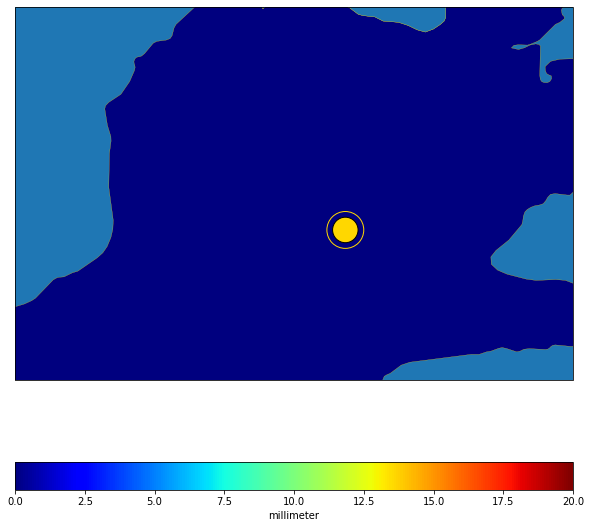

2022-03-08-2300
img : 1
f
(256, 256)


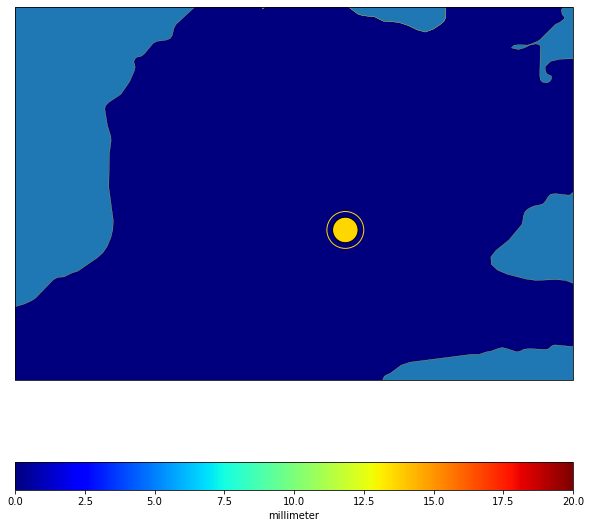

2022-03-08-2300
img : 2
f
(256, 256)


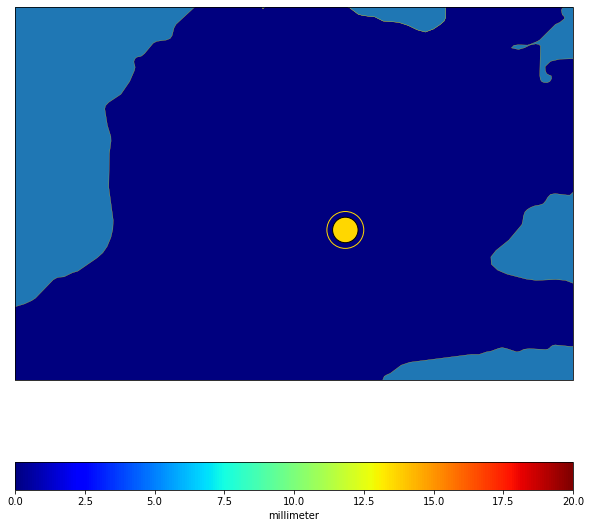

2022-03-08-2300
img : 3
f
(256, 256)


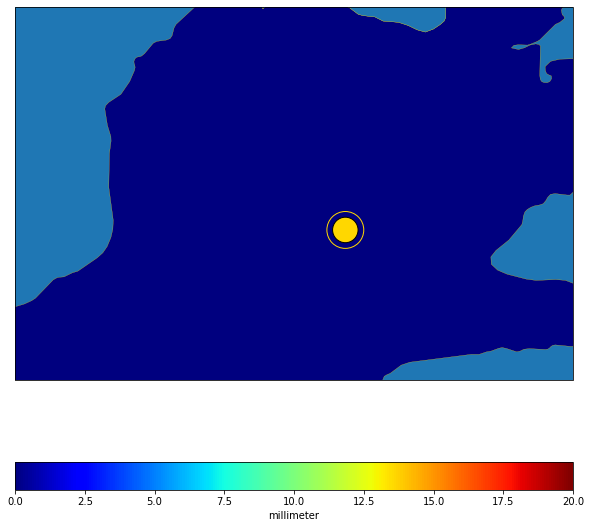

2022-03-08-2300
img : 4
f
(256, 256)


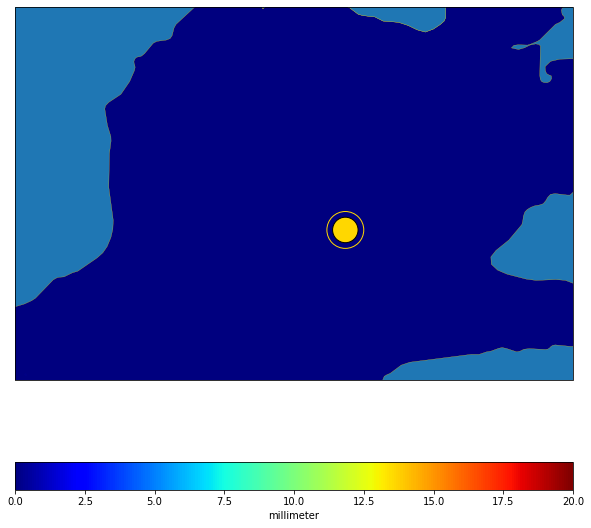

2022-03-08-2300
img : 5
f
(256, 256)


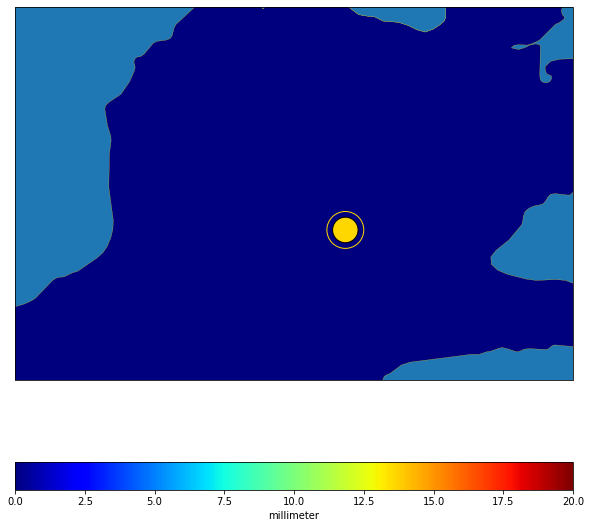

2022-03-08-2300
img : 6
f
(256, 256)


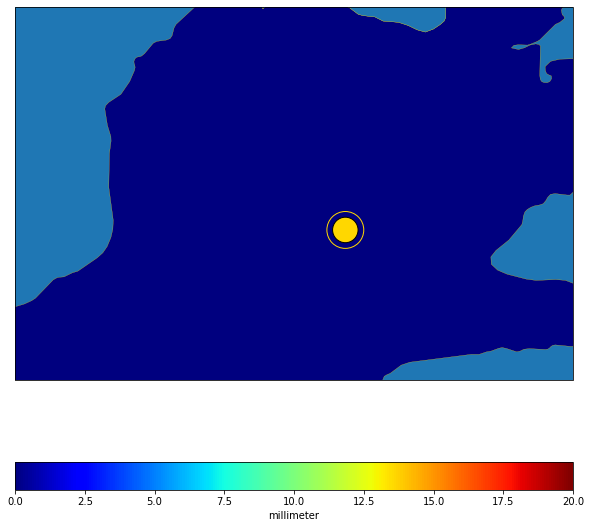

2022-03-08-2300
img : 7
f
(256, 256)


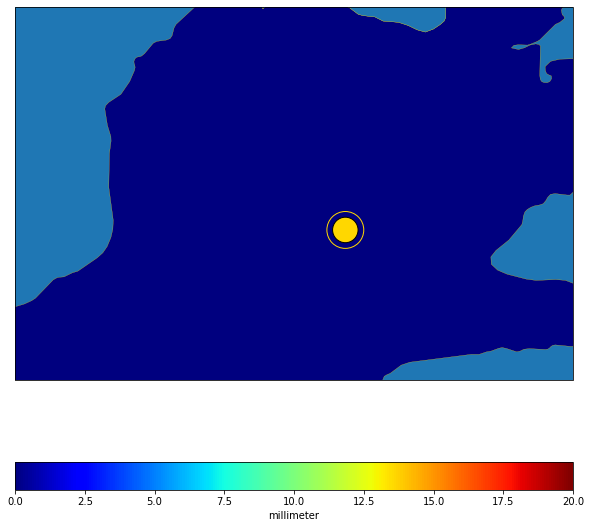

2022-03-08-2300
img : 8
f
(256, 256)


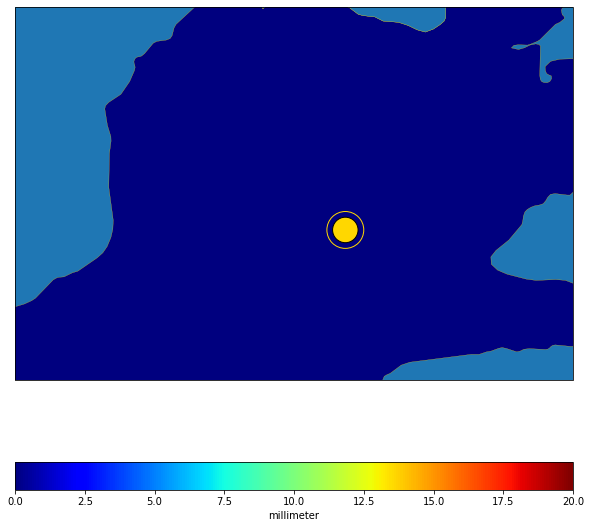

2022-03-08-2300


In [ ]:
#tmp = np.resize(samples,(samples.shape[0],samples.shape[1],3500,7000,samples.shape[4] ))
#tmp.shape
print(FrameRelatedData)
#plot_animation_grib(radar_frames,FrameRelatedData[0],vmin=0, vmax=20, cmap="jet")

if("1hr" in gribGroundTruthsPath):
  x = samples[0][::2]
else:
  x = samples[0]
plot_animation_grib(samples[0][::2],gribGroundTruthsPath,FrameRelatedData[3],w_specBounds,vmin=0, vmax=20, cmap="jet")